# Cybercrime Trends in Canada (2014-2024)

**Data Source:** Statistics Canada, Table 35-10-0001-01  
**Analysis:** Trends in cybercrime violations across Canada

This notebook analyzes cybercrime data from Statistics Canada, visualizing trends over the past decade and identifying the most common violation types.

## Setup and Dependencies

In [17]:
# Install required packages
!pip install -q openpyxl

In [18]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
from io import BytesIO
from pathlib import Path
from IPython.display import display, HTML

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Create output directory
output_dir = Path('outputs')
output_dir.mkdir(exist_ok=True)

print("Libraries loaded successfully")

Libraries loaded successfully


## Fetch Cybercrime Data from Statistics Canada

**Dataset:** Table 35-10-0001-01 - Police-reported cybercrime, by cyber-related violation  
**URL:** https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510000101

In [19]:
TABLE_ID = "35100001"

# Construct download URL
# Updated URL based on direct download links from Statistics Canada
download_url = f"https://www150.statcan.gc.ca/n1/tbl/csv/{TABLE_ID}-eng.zip"

print("Downloading cybercrime data from Statistics Canada...")
print(f"Table ID: {TABLE_ID}")

try:
    # Download the data
    response = requests.get(download_url, timeout=60)
    response.raise_for_status()

    # Extract ZIP file
    with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
        csv_files = [f for f in zip_file.namelist() if f.endswith('.csv')]

        if not csv_files:
            raise ValueError("No CSV file found in downloaded ZIP")

        csv_filename = csv_files[0]

        with zip_file.open(csv_filename) as csv_file:
            df_raw = pd.read_csv(csv_file)

    print(f"Data loaded: {len(df_raw):,} rows, {len(df_raw.columns)} columns")
    print(f"Time period: {df_raw['REF_DATE'].min()} to {df_raw['REF_DATE'].max()}")

except Exception as e:
    print(f"Error: {e}")
    raise

Table ID: 35100001
Data loaded: 297 rows, 15 columns
Time period: 2014 to 2024


In [20]:
# Explore the data structure
print("Columns:", df_raw.columns.tolist())
print("\nFirst few rows:")
df_raw.head()

Columns: ['REF_DATE', 'GEO', 'DGUID', 'Cyber-related violation', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']

First few rows:


,REF_DATE,GEO,DGUID,Cyber-related violation,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2014,"Canada, selected police services",NaN,"Total, all violations",Number,223,units,0,v116321049,1.1,15184,NaN,NaN,NaN,0
1,2014,"Canada, selected police services",NaN,Homicide and other related violations,Number,223,units,0,v116321050,1.2,0,NaN,NaN,NaN,0
2,2014,"Canada, selected police services",NaN,Invitation to sexual touching,Number,223,units,0,v116321051,1.3,160,NaN,NaN,NaN,0
3,2014,"Canada, selected police services",NaN,Sexual exploitation,Number,223,units,0,v116321052,1.4,11,NaN,NaN,NaN,0
4,2014,"Canada, selected police services",NaN,Luring a child via a computer,Number,223,units,0,v116321053,1.5,931,NaN,NaN,NaN,0


## Process and Clean Data

In [21]:
# Create a clean copy of the data
df = df_raw.copy()

# Convert REF_DATE to integer year
df['Year'] = df['REF_DATE'].astype(int)

# Filter for 2014-2024
df = df[df['Year'].between(2014, 2024)]

# Remove rows with missing values
df = df[df['VALUE'].notna()]

# Filter for Canada-level data only (exclude provinces)
if 'GEO' in df.columns:
    df = df[df['GEO'] == 'Canada, selected police services']

# Identify the violation column
violation_col = None
for col in df.columns:
    if 'violation' in col.lower() or 'offence' in col.lower():
        violation_col = col
        break

if violation_col is None:
    # Look for columns that might contain violation types
    for col in df.columns:
        if df[col].dtype == 'object' and col not in ['REF_DATE', 'GEO', 'DGUID', 'UOM', 'STATUS', 'SYMBOL', 'SCALAR_FACTOR']:
            unique_vals = df[col].nunique()
            if unique_vals > 5 and unique_vals < 500:
                violation_col = col
                break

print(f"Violation column: {violation_col}")
print(f"\nUnique violation types: {df[violation_col].nunique()}")
print(f"Years: {df['Year'].min()} to {df['Year'].max()}")
print(f"Total rows: {len(df):,}")

Violation column: Cyber-related violation

Unique violation types: 27
Years: 2014 to 2024
Total rows: 297


In [22]:
# Display sample violation types
print("Sample violation types:")
for i, v in enumerate(df[violation_col].unique()[:15], 1):
    print(f"  {i}. {v}")

Sample violation types:
  1. Total, all violations
  2. Homicide and other related violations
  3. Invitation to sexual touching
  4. Sexual exploitation
  5. Luring a child via a computer
  6. Voyeurism
  7. Non-consensual distribution of intimate images
  8. Extortion
  9. Criminal harassment
  10. Indecent or Harassing communications
  11. Uttering threats
  12. Other violent violations
  13. Fraud
  14. Identity theft
  15. Identity fraud


In [23]:
# Separate total cybercrime from specific violations
# Look for the total row
total_mask = df[violation_col].str.contains('Total|All cyber', case=False, na=False)

df_total = df[total_mask].copy()
df_violations = df[~total_mask].copy()

print(f"Total cybercrime rows: {len(df_total)}")
print(f"Specific violation rows: {len(df_violations)}")
print(f"\nSpecific violation types: {df_violations[violation_col].nunique()}")

Total cybercrime rows: 11
Specific violation rows: 286

Specific violation types: 26


## Line Graph: Cybercrime Trends (2014-2024)

Visualizing total cybercrime and the three most common cybercrime violation types over the past decade.

In [24]:
# Calculate yearly totals
if len(df_total) > 0:
    # Use the pre-calculated total from the dataset
    yearly_totals = df_total.groupby('Year')['VALUE'].sum().reset_index()
    yearly_totals.columns = ['Year', 'Total']
else:
    # Calculate total from individual violations
    yearly_totals = df_violations.groupby('Year')['VALUE'].sum().reset_index()
    yearly_totals.columns = ['Year', 'Total']

print("Yearly Total Cybercrime:")
print(yearly_totals.to_string(index=False))

Yearly Total Cybercrime:
 Year  Total
 2014  15184
 2015  17887
 2016  23996
 2017  27829
 2018  33893
 2019  48318
 2020  65141
 2021  71727
 2022  80246
 2023  98252
 2024  92567


In [25]:
# Find the top 3 most common violations (by total across all years)
violation_totals = df_violations.groupby(violation_col)['VALUE'].sum().sort_values(ascending=False)
top_3_violations = violation_totals.head(3)

print("Top 3 Most Common Cybercrime Violations (2014-2024):")
for i, (violation, total) in enumerate(top_3_violations.items(), 1):
    print(f"  {i}. {violation}: {total:,.0f} total incidents")

Top 3 Most Common Cybercrime Violations (2014-2024):
  1. Fraud: 275,967 total incidents
  2. Making or distribution of child pornography: 58,624 total incidents
  3. Indecent or Harassing communications: 44,845 total incidents


In [26]:
# Prepare data for the top 3 violations over time
top_3_names = top_3_violations.index.tolist()
df_top3 = df_violations[df_violations[violation_col].isin(top_3_names)]

# Pivot for plotting
df_pivot = df_top3.pivot_table(
    index='Year',
    columns=violation_col,
    values='VALUE',
    aggfunc='sum'
).fillna(0)

print("Yearly breakdown of top 3 violations:")
df_pivot

Yearly breakdown of top 3 violations:


Cyber-related violation,Fraud,Indecent or Harassing communications,Making or distribution of child pornography
Year,,,
2014,7332,730,0
2015,8429,1202,850
2016,11383,1655,2886
2017,13426,2302,2868
2018,16641,2708,3113
2019,22746,4996,4242
2020,29781,6187,5899
2021,34080,6711,5531
2022,39486,5997,7587


Graph saved to: outputs/cybercrime_trends_2014_2024.png


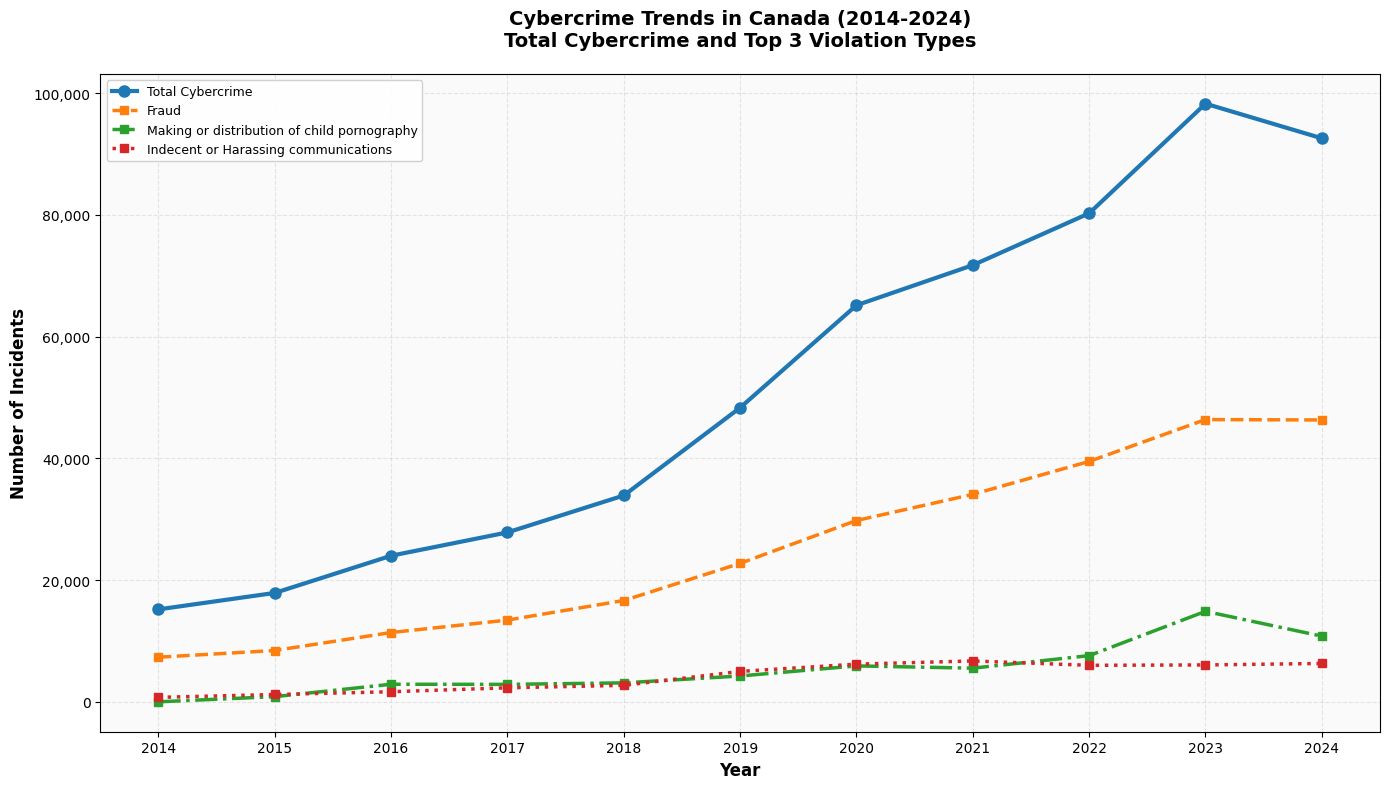

In [27]:
# Create the line graph
fig, ax = plt.subplots(figsize=(14, 8))

# Plot total cybercrime
ax.plot(yearly_totals['Year'], yearly_totals['Total'],
        marker='o', linewidth=3, markersize=8,
        label='Total Cybercrime', color='#1f77b4', linestyle='-')

# Colors and styles for top 3 violations
colors = ['#ff7f0e', '#2ca02c', '#d62728']
linestyles = ['--', '-.', ':']

# Plot top 3 violations
for i, violation in enumerate(top_3_names):
    if violation in df_pivot.columns:
        # Truncate long labels for legend
        label = violation if len(violation) <= 50 else violation[:47] + '...'
        ax.plot(df_pivot.index, df_pivot[violation],
                marker='s', linewidth=2.5, markersize=6,
                label=label, color=colors[i], linestyle=linestyles[i])

# Formatting
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Incidents', fontsize=12, fontweight='bold')
ax.set_title('Cybercrime Trends in Canada (2014-2024)\nTotal Cybercrime and Top 3 Violation Types',
             fontsize=14, fontweight='bold', pad=20)

# Configure axes
ax.set_xticks(range(2014, 2025))
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=9, loc='upper left', framealpha=0.9)

# Format y-axis with commas
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Background styling
ax.set_facecolor('#fafafa')
fig.patch.set_facecolor('white')

plt.tight_layout()

# Save the figure
output_path = output_dir / 'cybercrime_trends_2014_2024.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Graph saved to: {output_path}")

plt.show()

## Table: Top 20 Cybercrimes in 2024 with Growth Metrics

Analyzing the most common cybercrime violations in 2024 and their growth trends over the past 5 and 10 years.

In [28]:
# Get data for specific years
df_2024 = df_violations[df_violations['Year'] == 2024]
df_2019 = df_violations[df_violations['Year'] == 2019]
df_2014 = df_violations[df_violations['Year'] == 2014]

# Calculate totals by violation type for each year
violations_2024 = df_2024.groupby(violation_col)['VALUE'].sum()
violations_2019 = df_2019.groupby(violation_col)['VALUE'].sum()
violations_2014 = df_2014.groupby(violation_col)['VALUE'].sum()

# Get top 20 by 2024 count
top_20 = violations_2024.nlargest(20)

print(f"Top 20 cybercrimes in 2024: {len(top_20)} violations")

Top 20 cybercrimes in 2024: 20 violations


In [29]:
# Build the summary table
summary_data = []

for rank, (violation, count_2024) in enumerate(top_20.items(), 1):
    count_2019 = violations_2019.get(violation, 0)
    count_2014 = violations_2014.get(violation, 0)

    # Calculate 5-year growth (2019-2024)
    if count_2019 > 0:
        growth_5yr = ((count_2024 - count_2019) / count_2019) * 100
    else:
        growth_5yr = None  # New violation type

    # Calculate 10-year growth (2014-2024)
    if count_2014 > 0:
        growth_10yr = ((count_2024 - count_2014) / count_2014) * 100
    else:
        growth_10yr = None  # New violation type

    summary_data.append({
        'Rank': rank,
        'Violation Type': violation,
        '2024 Incidents': int(count_2024),
        '2019 Incidents': int(count_2019) if count_2019 > 0 else 0,
        '2014 Incidents': int(count_2014) if count_2014 > 0 else 0,
        'Growth 2019-2024 (%)': growth_5yr,
        'Growth 2014-2024 (%)': growth_10yr
    })

# Create DataFrame
df_summary = pd.DataFrame(summary_data)

print("Summary table created successfully")

Summary table created successfully


In [30]:
# Format the display table
df_display = df_summary.copy()

# Format numbers with commas
df_display['2024 Incidents'] = df_display['2024 Incidents'].apply(lambda x: f'{x:,}')

# Format growth percentages
def format_growth(x):
    if x is None:
        return 'N/A'
    elif x >= 1000:
        return f'+{x:,.0f}%'
    else:
        return f'{x:+.1f}%'

df_display['Growth 2019-2024 (%)'] = df_display['Growth 2019-2024 (%)'].apply(format_growth)
df_display['Growth 2014-2024 (%)'] = df_display['Growth 2014-2024 (%)'].apply(format_growth)

# Select columns for display
display_cols = ['Rank', 'Violation Type', '2024 Incidents', 'Growth 2019-2024 (%)', 'Growth 2014-2024 (%)']
df_display = df_display[display_cols]

print("="*100)
print("TOP 20 CYBERCRIMES IN CANADA (2024) WITH GROWTH METRICS")
print("="*100)
print(df_display.to_string(index=False))
print("="*100)

TOP 20 CYBERCRIMES IN CANADA (2024) WITH GROWTH METRICS
 Rank                                 Violation Type 2024 Incidents Growth 2019-2024 (%) Growth 2014-2024 (%)
    1                                          Fraud         46,301              +103.6%              +531.5%
    2    Making or distribution of child pornography         10,786              +154.3%                +nan%
    3           Indecent or Harassing communications          6,299               +26.1%              +762.9%
    4                                      Extortion          6,042              +317.6%              +1,270%
    5                               Uttering threats          4,934               +14.0%              +387.1%
    6                                 Identity fraud          4,283              +119.6%              +411.1%
    7                  Luring a child via a computer          2,965              +102.9%              +218.5%
    8                            Criminal harassment          2,

In [31]:
# Display as styled HTML table
styled_table = df_display.style.set_properties(**{
    'text-align': 'left',
    'font-size': '11px',
    'padding': '8px'
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#2E86AB'),
        ('color', 'white'),
        ('font-weight', 'bold'),
        ('text-align', 'center'),
        ('padding', '10px'),
        ('font-size', '11px')
    ]},
    {'selector': 'td', 'props': [
        ('border', '1px solid #ddd')
    ]},
    {'selector': 'tr:nth-of-type(even)', 'props': [
        ('background-color', '#f8f9fa')
    ]}
]).set_caption('Top 20 Cybercrimes in Canada (2024) with Growth Metrics')

display(styled_table)

,Rank,Violation Type,2024 Incidents,Growth 2019-2024 (%),Growth 2014-2024 (%)
0,1,Fraud,"46,301",+103.6%,+531.5%
1,2,Making or distribution of child pornography,"10,786",+154.3%,+nan%
2,3,Indecent or Harassing communications,"6,299",+26.1%,+762.9%
3,4,Extortion,"6,042",+317.6%,"+1,270%"
4,5,Uttering threats,"4,934",+14.0%,+387.1%
5,6,Identity fraud,"4,283",+119.6%,+411.1%
6,7,Luring a child via a computer,"2,965",+102.9%,+218.5%
7,8,Criminal harassment,"2,929",+7.7%,+225.8%
8,9,Child pornography,"2,192",+93.5%,+11.6%
9,10,Fail to comply with order,"1,233",+119.0%,"+1,097%"


In [32]:
# Save the table to CSV
csv_path = output_dir / 'top_20_cybercrimes_2024.csv'
df_summary.to_csv(csv_path, index=False)
print(f"Table saved to: {csv_path}")

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

total_2024 = df_summary['2024 Incidents'].sum()
print(f"Total incidents in top 20 (2024): {total_2024:,}")

# Average growth rates (excluding None values)
valid_5yr = [x for x in df_summary['Growth 2019-2024 (%)'] if x is not None]
valid_10yr = [x for x in df_summary['Growth 2014-2024 (%)'] if x is not None]

if valid_5yr:
    print(f"Average 5-year growth (2019-2024): {np.mean(valid_5yr):+.1f}%")
    print(f"Median 5-year growth (2019-2024): {np.median(valid_5yr):+.1f}%")

if valid_10yr:
    print(f"Average 10-year growth (2014-2024): {np.mean(valid_10yr):+.1f}%")
    print(f"Median 10-year growth (2014-2024): {np.median(valid_10yr):+.1f}%")

print("="*60)

Table saved to: outputs/top_20_cybercrimes_2024.csv

SUMMARY STATISTICS
Total incidents in top 20 (2024): 92,461
Average 5-year growth (2019-2024): +97.9%
Median 5-year growth (2019-2024): +98.2%
Average 10-year growth (2014-2024): +nan%
Median 10-year growth (2014-2024): +nan%


## Analysis Complete

**Outputs Generated:**
- Line graph: `outputs/cybercrime_trends_2014_2024.png`
- Data table: `outputs/top_20_cybercrimes_2024.csv`

**Data Source:**  
Statistics Canada, Table 35-10-0001-01: Police-reported cybercrime, by cyber-related violation  
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510000101